### Read the train and test logits/likelyhoods

In [21]:
import torch
import os
import tifffile as tiff
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
import torch.optim as optim
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from itertools import product
import concurrent.futures
from sklearn.metrics import average_precision_score
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax
import optuna
from scipy.special import expit
from sklearn.metrics import f1_score

val_path = 'calibration_logits.pth'
test_path = 'test_logits.pth'

val_data = torch.load(val_path, weights_only=False)
test_data = torch.load(test_path, weights_only=False)

val_logits = val_data["logits"] 
val_images = val_data["images"]  
val_labels = val_data["masks"]    
val_probs = F.softmax(val_logits, dim=1)

test_logits = test_data["logits"] 
test_images = test_data["images"]  
test_labels = test_data["masks"]    
test_probs = F.softmax(test_logits, dim=1)

### Frameworks

#### Metrics

In [33]:
class Metrics:

    def flatten_probs_labels(probs, labels):
        N, C, H, W = probs.shape
        probs_flat = probs.permute(0, 2, 3, 1).reshape(-1, C)  # (N*H*W, C)
        labels_flat = labels.view(-1)  # (N*H*W,)
        return probs_flat, labels_flat

    def compute_average_precision(probs, labels, num_classes=4):
        probs_flat, labels_flat = Metrics.flatten_probs_labels(probs, labels)
        AP_per_class = []

        for c in range(num_classes):
            # True binary labels for class c (1 if pixel == c, 0 otherwise)
            true_binary = (labels_flat == c).cpu().numpy()
            # Probabilities for class c
            prob_c = probs_flat[:, c].cpu().numpy()

            if np.sum(true_binary) == 0:
                AP_per_class.append(np.nan)  # No positive samples, skip
            else:
                AP = average_precision_score(true_binary, prob_c)
                AP_per_class.append(AP)

        # Mean AP (mAP), ignoring NaNs
        mAP = np.nanmean(AP_per_class)
        return AP_per_class, mAP

    def compute_ece(probs, labels, num_bins=10):
        # Convert to numpy
        probs_flat, labels_flat = Metrics.flatten_probs_labels(probs, labels)
        confidences, predictions = torch.max(probs_flat, dim=1)
        confidences = confidences.cpu().numpy()
        predictions = predictions.cpu().numpy()
        labels_flat = labels_flat.cpu().numpy()

        bin_boundaries = np.linspace(0.0, 1.0, num_bins + 1)
        ece = 0.0

        for i in range(num_bins):
            bin_lower = bin_boundaries[i]
            bin_upper = bin_boundaries[i + 1]

            in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
            prop_in_bin = np.mean(in_bin)

            if prop_in_bin > 0:
                accuracy_in_bin = np.mean(predictions[in_bin] == labels_flat[in_bin])
                avg_confidence_in_bin = np.mean(confidences[in_bin])
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

    def calculate_coverage(probs, thresholds):
        # Create confident mask: True if prob > threshold for each class
        confident_mask = torch.zeros_like(probs, dtype=torch.bool)
        for c in range(probs.shape[1]):
            confident_mask[:, c, :, :] = probs[:, c, :, :] > thresholds[c]
        # A pixel is certain if at least one class is confident
        certain_pixels = confident_mask.max(dim=1).values  # (N, H, W)
        coverage = float(certain_pixels.sum().item()) / certain_pixels.numel()
        return coverage
    
    def print_metrics(probs, labels, thresholds, name=None, force_full_coverage=False):
        APs, mAP = Metrics.compute_average_precision(probs, labels)
        ece = Metrics.compute_ece(probs, labels)
        
        if force_full_coverage:
            coverage = 1.0
        else:
            coverage = Metrics.calculate_coverage(probs, thresholds)

        print(f"\n=== {name} ===")
        print("Average Precision per class:", [f"{ap:.4f}" if ap is not None and not np.isnan(ap) else "nan" for ap in APs])
        print("Mean Average Precision (mAP):", f"{mAP:.4f}")
        print("Expected Calibration Error (ECE):", f"{ece:.4f}")
        print("Coverage (proportion of certain pixels):", f"{coverage:.4f}")

    def plot_segmentation_comparison_with_uncertainty(images, masks, preds_baseline, preds_imprecise, image_idx=0, ignore_class=255):
        img = images[image_idx][:3].permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())

        gt = masks[image_idx].cpu().numpy()
        base = preds_baseline[image_idx].cpu().numpy()
        cons = preds_imprecise[image_idx].cpu().numpy()

        cons_vis = cons.copy()
        cons_vis[cons_vis == ignore_class] = -1  
        
        # Plot
        fig, axs = plt.subplots(1, 4, figsize=(24, 5))
        axs[0].imshow(img)
        axs[0].set_title("Original Image")
        axs[1].imshow(gt, cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[2].imshow(base, cmap='gray')
        axs[2].set_title("Baseline Prediction")
        axs[3].imshow(cons_vis, cmap='gray')
        axs[3].set_title("Prediction with Imprecise Probabilities")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    def compute_metrics_certain_pixels(probs, labels, confident_mask, num_classes=4):
        # A pixel is certain if at least one class is confident
        certain_pixels = confident_mask.max(dim=1).values.bool()  # (N, H, W)
        
        # Flatten everything
        N, C, H, W = probs.shape
        probs_flat = probs.permute(0, 2, 3, 1).reshape(-1, C)
        labels_flat = labels.view(-1)
        certain_flat = certain_pixels.view(-1)
        
        # Filter only certain pixels
        probs_certain = probs_flat[certain_flat]
        labels_certain = labels_flat[certain_flat]
        
        # Coverage: proportion of certain pixels
        coverage = float(certain_flat.sum().item()) / certain_flat.numel()
        
        # If no certain pixels, return NaN
        if probs_certain.shape[0] == 0:
            return [float('nan')] * num_classes, float('nan'), float('nan'), 0.0
        
        # Average Precision
        AP_per_class = []
        for c in range(num_classes):
            true_binary = (labels_certain == c).cpu().numpy()
            prob_c = probs_certain[:, c].cpu().numpy()
            if np.sum(true_binary) == 0:
                AP_per_class.append(np.nan)
            else:
                AP = average_precision_score(true_binary, prob_c)
                AP_per_class.append(AP)
        mAP = np.nanmean(AP_per_class)
        
        # ECE
        confidences = probs_certain.max(dim=1).values.cpu().numpy()
        predictions = probs_certain.argmax(dim=1).cpu().numpy()
        labels_certain_np = labels_certain.cpu().numpy()
        num_bins = 10
        bin_boundaries = np.linspace(0.0, 1.0, num_bins + 1)
        ece = 0.0
        for i in range(num_bins):
            bin_lower = bin_boundaries[i]
            bin_upper = bin_boundaries[i + 1]
            in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
            prop_in_bin = np.mean(in_bin)
            if prop_in_bin > 0:
                accuracy_in_bin = np.mean(predictions[in_bin] == labels_certain_np[in_bin])
                avg_confidence_in_bin = np.mean(confidences[in_bin])
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        print(f"\n=== Imprecise Probability Approach Metrics for Certain Pixels ===")
        print("Average Precision per class:", [f"{ap:.4f}" if ap is not None and not np.isnan(ap) else "nan" for ap in AP_per_class])
        print("Mean Average Precision (mAP):", f"{mAP:.4f}")
        print("Expected Calibration Error (ECE):", f"{ece:.4f}")
        print("Coverage (proportion of certain pixels):", f"{coverage:.4f}")

#### Imprecise Probability

In [23]:
class ImpreciseProbsframe:

    def obtain_lower_bound(probs, alpha=0.1, eps=1e-6):
        entropy = -torch.sum(probs * torch.log(probs + eps), dim=1)  # (N, H, W)
        lower_bound = (probs - alpha * entropy.unsqueeze(1)).clamp(0, 1)       # (N, C, H, W)
        return lower_bound

    def plot_lower_bound_distribution(lower_bound, labels, sample_size=10000):
        N, C, H, W = lower_bound.shape
        plt.figure(figsize=(8, 4))

        for c in range(C):
            mask = (labels == c).unsqueeze(1)  # shape: (N, 1, H, W)
            lower_c = lower_bound[:, c, :, :][mask.squeeze(1)]

            if lower_c.numel() > sample_size:
                indices = torch.randperm(lower_c.numel())[:sample_size]
                lower_c = lower_c[indices]

            sns.kdeplot(lower_c.cpu().numpy(), label=f'Classe {c}', linewidth=2)

        plt.title("Distribution of Lower Bounds by Class")
        plt.xlabel("Lower Bound")
        plt.ylabel("Estimated Density")
        plt.legend()
        plt.xticks(np.arange(0, 1.1, 0.1)) 
        plt.grid(True)
        plt.show()

    def obtain_confident_values(lower_bound, thresholds):
        num_classes = lower_bound.shape[1]
        confident_mask = torch.zeros_like(lower_bound, dtype=torch.bool)

        for c in range(num_classes):
            confident_mask[:, c, :, :] = lower_bound[:, c, :, :] > thresholds[c]

        confident_probs = confident_mask.float() * lower_bound

        confident_preds = confident_probs.argmax(dim=1)
        is_uncertain = confident_mask.max(dim=1).values == 0
        confident_preds[is_uncertain] = 255  # 255 for uncertain pixels

        return confident_preds, confident_probs, confident_mask
    
    def fill_uncertain_probs_with_baseline(confident_values, confident_mask, baseline_probs):
        # Create a mask of uncertain pixels (1 if all classes are uncertain)
        uncertain_mask = confident_mask.max(dim=1).values == 0  # (N, H, W)

        # Start with confident_values, but baseline_probs will overwrite uncertain pixels
        final_probs = confident_values.clone()

        # For uncertain pixels, fill with baseline_probs
        for c in range(final_probs.shape[1]):
            final_probs[:, c, :, :][uncertain_mask] = baseline_probs[:, c, :, :][uncertain_mask]

        # Final predictions (argmax)
        pred_filled = final_probs.argmax(dim=1)
        return final_probs, pred_filled

#### Quartile Approach

In [24]:
class QuartileApproach:

    def thresholds_from_lower_percentile(lower_bound, labels, quartile, max_samples=100_000):
        N, C, H, W = lower_bound.shape

        thresholds = []
        for c in range(C):
            mask = (labels == c).unsqueeze(1)  # shape: (N, 1, H, W)
            lower_c = lower_bound[:, c, :, :][mask.squeeze(1)]

            if lower_c.numel() == 0:
                thresholds.append(0.5)  # fallback
            else:
                if lower_c.numel() > max_samples:
                    indices = torch.randperm(lower_c.numel())[:max_samples]
                    lower_c = lower_c[indices]
                
                    if f'class{c}' in quartile:
                        q = quartile[f'class{c}']
                        
                threshold = torch.quantile(lower_c, q).item()
                thresholds.append(threshold)
        return thresholds

    def optimize_quartiles(cal_lower_bound, cal_gt_masks, cal_probs, num_folds=3, quartile_range=[0.25, 0.5, 0.75], num_classes=3):
        N = cal_lower_bound.shape[0]
        indices = np.arange(N)
        np.random.shuffle(indices)
        fold_size = N // num_folds

        best_quartiles = {}
        best_score = -float('inf')

        quartile_combinations = list(product(quartile_range, repeat=num_classes))

        def evaluate_quartile_combo(combo):
            quartile = {f'class{c}': combo[c] for c in range(num_classes)}
            scores = []
            for fold in range(num_folds):
                val_indices = indices[fold * fold_size:(fold + 1) * fold_size]
                train_indices = np.setdiff1d(indices, val_indices)

                train_lower_bound = cal_lower_bound[train_indices]
                train_gt_masks = cal_gt_masks[train_indices]
                thresholds = QuartileApproach.thresholds_from_lower_percentile(train_lower_bound, train_gt_masks, quartile)

                val_lower_bound = cal_lower_bound[val_indices]
                val_gt_masks = cal_gt_masks[val_indices]
                val_probs = cal_probs[val_indices]

                _, confident_values, confident_mask = ImpreciseProbsframe.obtain_confident_values(val_lower_bound, thresholds)
                final_probs, _ = ImpreciseProbsframe.fill_uncertain_probs_with_baseline(confident_values, confident_mask, val_probs)

                _, mAP = Metrics.compute_average_precision(final_probs, val_gt_masks, num_classes=num_classes)
                ece = Metrics.compute_ece(final_probs, val_gt_masks)

                score = mAP - ece
                scores.append(score)
            avg_score = np.mean(scores)
            return avg_score, quartile

        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(executor.map(evaluate_quartile_combo, quartile_combinations))

        for avg_score, quartile in results:
            if avg_score > best_score:
                best_score = avg_score
                best_quartiles = quartile.copy()

        return best_quartiles
    

#### CRF

In [ ]:
class CRFApproach:
    def __init__(self, labels, probs, num_classes):
        self.labels = labels  # shape (N, H, W)
        self.probs = probs    # shape (N, C, H, W)
        self.num_classes = num_classes
    
    def _apply_crf_refinement(self, prob_unary, sxy_gaussian, compat_gaussian, iterations=10, epsilon=1e-8):
        C, H, W = prob_unary.shape
        d = dcrf.DenseCRF2D(W, H, C)

        unary = -np.log(prob_unary + epsilon).reshape(C, -1).astype(np.float32)
        d.setUnaryEnergy(unary)

        d.addPairwiseGaussian(sxy=sxy_gaussian, compat=compat_gaussian)
        Q = d.inference(iterations)
        refined_probs = np.array(Q).reshape((C, H, W))
        return refined_probs

    def _objective(self, trial):
        sxy_gaussian = trial.suggest_categorical("sxy_gaussian", [1, 3, 5])
        compat_gaussian = trial.suggest_float("compat_gaussian", 1, 5)
        return self._crf_loss([sxy_gaussian, compat_gaussian])

    def _crf_loss(self, params):
        n_samples = self.probs.shape[0]
        sxy_gaussian, compat_gaussian = params
        all_probs = []
        all_labels = []

        for i in range(n_samples):
            prob = self.probs[i].numpy()  # (C, H, W)
            label = self.labels[i].numpy()  # (H, W)

            like_map = self._apply_crf_refinement(prob, sxy_gaussian, compat_gaussian)  # (C, H, W)

            all_probs.append(torch.tensor(like_map))
            all_labels.append(torch.tensor(label))

        all_probs = torch.stack(all_probs)  # (N, C, H, W)
        all_labels = torch.stack(all_labels)  # (N, H, W)

        _, mAP = self._compute_average_precision(all_probs, all_labels, num_classes=self.num_classes)
        return 1.0 - mAP 
    
    def _compute_average_precision(self, probs, labels, num_classes=3):
        probs_flat, labels_flat = Metrics.flatten_probs_labels(probs, labels)
        AP_per_class = []

        for c in range(num_classes):
            true_binary = (labels_flat == c).cpu().numpy()
            prob_c = probs_flat[:, c].cpu().numpy()

            if np.sum(true_binary) == 0:
                AP_per_class.append(np.nan) 
            else:
                AP = average_precision_score(true_binary, prob_c)
                AP_per_class.append(AP)

        mAP = np.nanmean(AP_per_class)
        return AP_per_class, mAP
    
    def fit(self, n_trials=10):
        study = optuna.create_study(direction="minimize")
        study.optimize(self._objective, n_trials=n_trials)
        self.best_params = study.best_params

    def inference(self, probs_inf, confident_mask, confident_values):
        n_samples = probs_inf.shape[0]
        sxy = int(self.best_params["sxy_gaussian"])
        compat = float(self.best_params["compat_gaussian"])
        C, H, W = probs_inf.shape[1:]

        final_probs = []

        for i in range(n_samples):
            prob = probs_inf[i].numpy()  # (C, H, W)
            conf_mask = confident_mask[i].numpy()  # (C, H, W)

            uncertain_pixels = ~conf_mask.any(axis=0)  # (H, W)

            if not np.any(uncertain_pixels):
                final_probs.append(confident_values[i])
                continue

            crf_refined = self._apply_crf_refinement(prob, sxy, compat)  # (C, H, W)

            filled = confident_values[i].clone().numpy()

            for c in range(C):
                filled[c][uncertain_pixels] = crf_refined[c][uncertain_pixels]

            final_probs.append(torch.tensor(filled))

        final_probs = torch.stack(final_probs)  # (N, C, H, W)
        pred = final_probs.argmax(dim=1)  # (N, H, W)
        return final_probs, pred


### Use the Frameworks

#### Plot of Lower Bounds

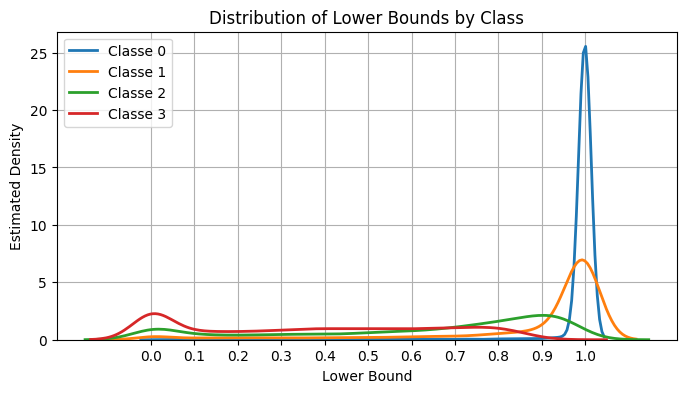

In [26]:
val_lower_bound = ImpreciseProbsframe.obtain_lower_bound(val_probs, alpha=0.1)
test_lower_bound = ImpreciseProbsframe.obtain_lower_bound(test_probs, alpha=0.1)

ImpreciseProbsframe.plot_lower_bound_distribution(val_lower_bound, val_labels)

#### Quartiles and Thresholds

In [27]:
optimized_quartiles = QuartileApproach.optimize_quartiles(val_lower_bound, val_labels, val_probs, num_folds=3, quartile_range=[0.25, 0.5, 0.75], num_classes=4)
thresholds = QuartileApproach.thresholds_from_lower_percentile(val_lower_bound, val_labels, optimized_quartiles)
print("Thresholds for each class:", [f"{t:.4f}" for t in thresholds])

Thresholds for each class: ['0.9999', '0.9991', '0.8806', '0.6278']


#### CRF

In [28]:
crf_model = CRFApproach(labels=val_labels, probs=val_probs, num_classes=4)
crf_model.fit(n_trials=20)

[I 2025-07-12 09:10:37,220] A new study created in memory with name: no-name-d0b8bd27-2cef-4b53-a9dc-11d84aefe1ee
[I 2025-07-12 09:11:18,733] Trial 0 finished with value: 0.23781090297993035 and parameters: {'sxy_gaussian': 5, 'compat_gaussian': 2.8947047226086404}. Best is trial 0 with value: 0.23781090297993035.
[I 2025-07-12 09:11:59,928] Trial 1 finished with value: 0.23676998960041806 and parameters: {'sxy_gaussian': 5, 'compat_gaussian': 2.6110510599158916}. Best is trial 1 with value: 0.23676998960041806.
[I 2025-07-12 09:12:40,599] Trial 2 finished with value: 0.24656447401541848 and parameters: {'sxy_gaussian': 5, 'compat_gaussian': 4.997338406380775}. Best is trial 1 with value: 0.23676998960041806.
[I 2025-07-12 09:13:21,374] Trial 3 finished with value: 0.24322692299489623 and parameters: {'sxy_gaussian': 5, 'compat_gaussian': 4.178774651109883}. Best is trial 1 with value: 0.23676998960041806.
[I 2025-07-12 09:14:03,065] Trial 4 finished with value: 0.2335219177711152 and 

#### Imprecise Probability

In [29]:
confident_preds, confident_values, confident_mask = ImpreciseProbsframe.obtain_confident_values(test_lower_bound, thresholds)
final_probs_crf, pred_crf_filled = crf_model.inference(test_probs, confident_mask, confident_values)

#### Print Metrics and compare

In [34]:
Metrics.print_metrics(test_probs, test_labels, thresholds, name="Baseline Metrics", force_full_coverage=True)
Metrics.print_metrics(final_probs_crf, test_labels, thresholds, name="Imprecise Probability with CRF Approach Metrics")
Metrics.compute_metrics_certain_pixels(confident_values, test_labels, confident_mask)


=== Baseline Metrics ===
Average Precision per class: ['0.9997', '0.9828', '0.6978', '0.3823']
Mean Average Precision (mAP): 0.7657
Expected Calibration Error (ECE): 0.0023
Coverage (proportion of certain pixels): 1.0000

=== Imprecise Probability with CRF Approach Metrics ===
Average Precision per class: ['0.9996', '0.9814', '0.6617', '0.3296']
Mean Average Precision (mAP): 0.7431
Expected Calibration Error (ECE): 0.0077
Coverage (proportion of certain pixels): 0.8033

=== Imprecise Probability Approach Metrics for Certain Pixels ===
Average Precision per class: ['0.9998', '0.9915', '0.8752', '0.6694']
Mean Average Precision (mAP): 0.8840
Expected Calibration Error (ECE): 0.0016
Coverage (proportion of certain pixels): 0.3052
